Load all packages you need.

In [2]:
# load libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

Read the data.

In [3]:
df = pd.read_csv('data/pima-indians-diabetes-database/diabetes.csv')

Let's deal with the missing data points in "BloodPressure". <br>
First remove the outlier from the last coding break.<br>
Create a copy of the outlier-filtered data frame and impute the missing values with the "BloodPressure" median value.

In [4]:
# Filter outlier
valid_bp = df[df['BloodPressure'] > 0]['BloodPressure']
Q1 = valid_bp.quantile(0.25)
Q3 = valid_bp.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_filtered = df[(df['BloodPressure'] == 0) | ((df['BloodPressure'] >= lower_bound) & (df['BloodPressure'] <= upper_bound))]

# Perform median imputation
df_median_imputed = df_filtered.copy()
median_bp = df_median_imputed[df_median_imputed['BloodPressure'] > 0]['BloodPressure'].median()
df_median_imputed['BloodPressure'] = df_median_imputed['BloodPressure'].replace(0, median_bp)

Create a second copy of the outlier-filtered data frame. <br>
Perform a hot-deck/distribution imputation. First, estimate the distribution parameters of "BloodPressure". Then, sample the values used for imputation.

In [5]:
df_hotdeck_imputed = df_filtered.copy()

# Fit normal distribution parameters to BloodPressure
mean_bp = valid_bp.mean()
std_bp = valid_bp.std()

# Replace missing BloodPressure values with samples from the fitted normal distribution
missing_indices = df_hotdeck_imputed['BloodPressure'] == 0
df_hotdeck_imputed.loc[missing_indices, 'BloodPressure'] = np.random.normal(mean_bp, std_bp, missing_indices.sum()).astype(int)

Create a third copy of the outlier-filtered data frame. <br>
Perform a regression-based imputation. First, choose 3 variables that are correlated with "BloodPressure" (Hint, create a correlation matrix or have a look at the "Associations"-Button in sweetviz).<br>
Second, fit a linear regression model with those three variables as predictors. Let's ignore for the moment that the other variables might also include outlier and missing data.<br>
Now, use the regression model to estimate the imputed value for each missing data point.

In [7]:
# Create a third copy for regression-based imputation
df_lin_reg_imputed = df_filtered.copy()

# Prepare the dataset for regression-based imputation
existing_data = df_lin_reg_imputed[df_lin_reg_imputed['BloodPressure'] > 0]
missing_data = df_lin_reg_imputed[df_lin_reg_imputed['BloodPressure'] == 0]

# Fit linear regression model
regressor = LinearRegression()
regressor.fit(existing_data[['SkinThickness', 'BMI', 'Age']], existing_data['BloodPressure'])

# Predict missing values
predicted_values = regressor.predict(missing_data[['SkinThickness', 'BMI', 'Age']])
df_lin_reg_imputed.loc[df_lin_reg_imputed['BloodPressure'] == 0, 'BloodPressure'] = predicted_values.astype(int)

Now plot the original data next to the imputed data. Inspect the differences!

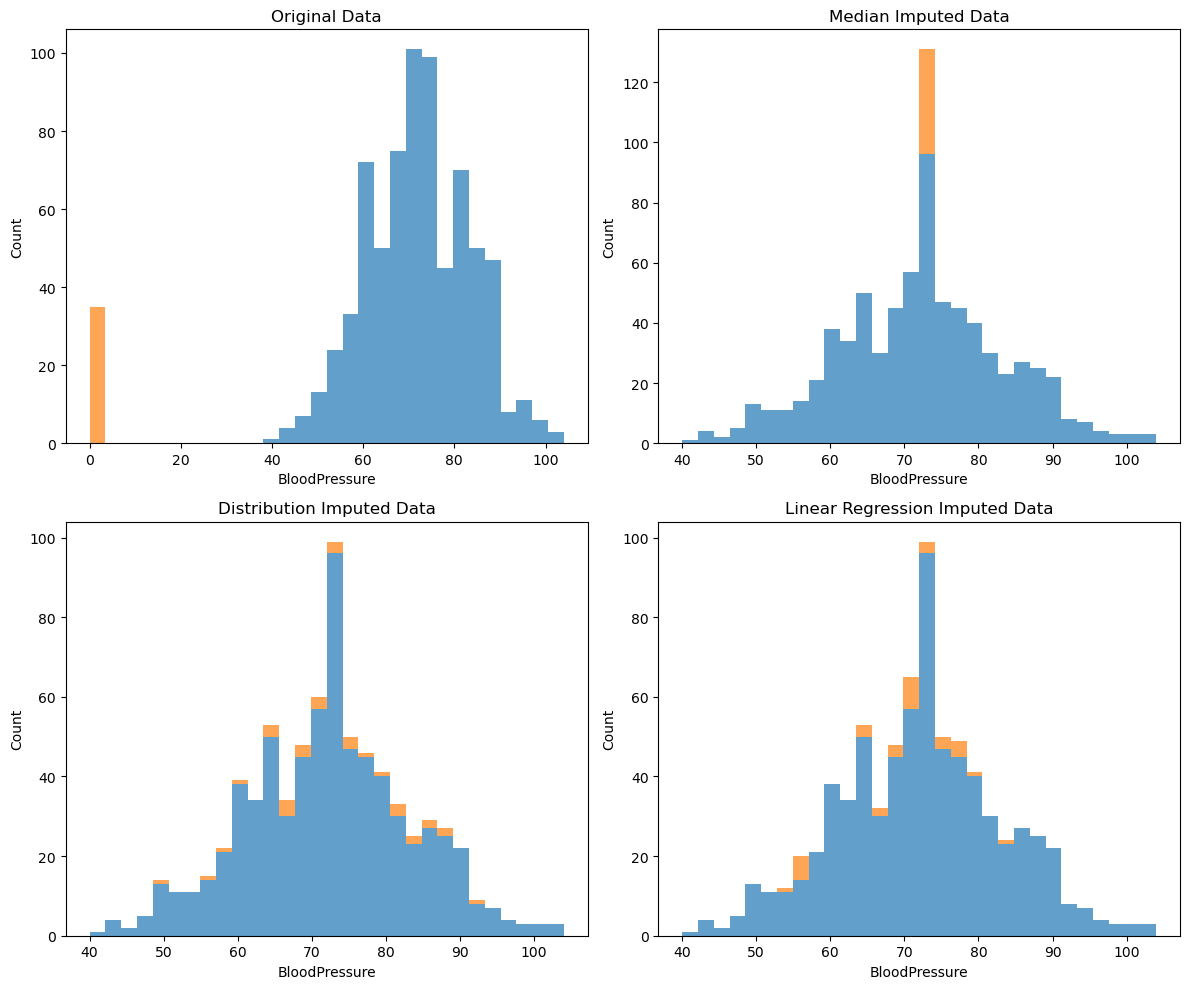

In [27]:
df_filtered.loc[:, 'BloodPressureMissing'] = df_filtered['BloodPressure'] == 0
df_median_imputed['BloodPressureMissing'] = df_filtered['BloodPressureMissing']
df_hotdeck_imputed['BloodPressureMissing'] = df_filtered['BloodPressureMissing']
df_lin_reg_imputed['BloodPressureMissing'] = df_filtered['BloodPressureMissing']

# Plot stacked histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

def plot_histogram(ax, df, title):
    data_0 = df[df['BloodPressureMissing'] == 0]['BloodPressure']
    data_1 = df[df['BloodPressureMissing'] == 1]['BloodPressure']

    ax.hist([data_0, data_1], bins=30, stacked=True, label=['Not Missing', 'Missing'], alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('BloodPressure')
    ax.set_ylabel('Count')
    #ax.legend(["Not Missing", "Missing"])

plot_histogram(axes[0, 0], df_filtered, "Original Data")
plot_histogram(axes[0, 1], df_median_imputed, "Median Imputed Data")
plot_histogram(axes[1, 0], df_hotdeck_imputed, "Distribution Imputed Data")
plot_histogram(axes[1, 1], df_lin_reg_imputed, "Linear Regression Imputed Data")

plt.tight_layout()
plt.show()